# ARIMA prediction for Bitcoin value
Autoregressive integrated moving average is used for predicting future points in timeseries data. In this model, regression analysis is computed which indicated strength of a dependant variable relative to changing ones. Model can predict the future of values based on own properties.

In [23]:
!pip3 install psycopg2-binary

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [25]:
#Get data from data warehouse on AWS RDS
#Since we have a lot of data, we will be just using a subset of the actual data for prediction
#We will be filtering data for last 5 years of available data to do this

import sqlalchemy

username = "postgres"
password = "postgres"
endpoint = "crypto-warehouse.cdvabacdldda.us-west-1.rds.amazonaws.com" 
dbname   = "BitcoinDataMart"

con = sqlalchemy.create_engine("postgresql://%s:%s@%s/%s" % (username, password, endpoint, dbname))

df = pd.read_sql("SELECT \"unix\", \"Open\", \"high\", \"low\", \"Close\", \"volume-coin\", \"volume-usd\",\
                 \"date\", \"just_date\", \"just_time\"\
                 FROM bitcoin_datamart_data where date >= '2012-01-01' and date <='2017-06-01'  ", con)
print(pd.__version__)
df.head()

1.4.1


,unix,Open,high,low,Close,volume-coin,volume-usd,date,just_date,just_time
0,1475279880,608.23,608.23,608.23,608.23,0.133542,81.22409,2016-09-30 23:58:00,2016-09-30,23:58:00
1,1475279940,608.23,608.23,608.23,608.23,0.819249,498.29156,2016-09-30 23:59:00,2016-09-30,23:59:00
2,1475280060,608.23,608.25,608.23,608.25,2.390576,1454.03580,2016-10-01 00:01:00,2016-10-01,00:01:00
3,1475280120,608.39,608.47,608.39,608.47,1.384715,842.45465,2016-10-01 00:02:00,2016-10-01,00:02:00
4,1475280180,608.81,608.81,608.81,608.81,0.063840,38.86673,2016-10-01 00:03:00,2016-10-01,00:03:00


In [26]:
#Data Cleaning
#Although we have cleaned the data in Spark, but still for safety we will check and clean again
#Finding Null Values
df.isna().sum()

unix           0
Open           0
high           0
low            0
Close          0
volume-coin    0
volume-usd     0
date           0
just_date      0
just_time      0
dtype: int64

In [27]:
#Replacing NA for all the above columns with the mean value grouped by that day
df['Open'] = df['Open'].fillna(df.groupby('date')['Open'].transform('mean'))
df['high'] = df['high'].fillna(df.groupby('date')['high'].transform('mean'))
df['low'] = df['low'].fillna(df.groupby('date')['low'].transform('mean'))
df['Close'] = df['Close'].fillna(df.groupby('date')['Close'].transform('mean'))
df['volume-usd'] = df['volume-usd'].fillna(df.groupby('date')['volume-usd'].transform('mean'))


In [28]:
#Checking the results
df.isna().sum()

unix           0
Open           0
high           0
low            0
Close          0
volume-coin    0
volume-usd     0
date           0
just_date      0
just_time      0
dtype: int64

In [29]:
#If incase we still have na values that means that we have null values for all values of that day.
#Thus it makes sense to drop them since they will harm our models accuracy
df = df.dropna()

In [30]:
#Rechecking
df.isna().sum()


unix           0
Open           0
high           0
low            0
Close          0
volume-coin    0
volume-usd     0
date           0
just_date      0
just_time      0
dtype: int64

In [31]:
# Change epoch time to datetime 
df.date = pd.to_datetime(df.date)

# Resampling to daily frequency
df.index = df.date

# Pulled and processed dataset from datawarehouse may not have weighted average values, 
#so here I am calculating the weighed average. This value us the average proce of the asset for a given period 
#weighted by volume.
#This value will be used for prediction.

df['my_weighted_avg'] = df[['high','low','Close']].mean(axis=1)


df = df.resample('D').mean()

# # Resampling to monthly frequency
df_month = df.resample('M').mean()

# # Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# # Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()
df.columns


df.head()

,unix,Open,high,low,Close,volume-coin,volume-usd,my_weighted_avg
date,,,,,,,,
2012-01-01,1.325427e+09,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,1.325535e+09,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,1.325605e+09,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,1.325682e+09,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.215556
2012-01-05,1.325771e+09,6.281429,6.286190,6.281429,6.286190,4.514373,27.987370,6.284603


When we are finding time series decomposition we need to understand if the provided data is seasonal, trend, residual etc. 

Dickey–Fuller test: p=0.998762


<Figure size 1080x1440 with 0 Axes>

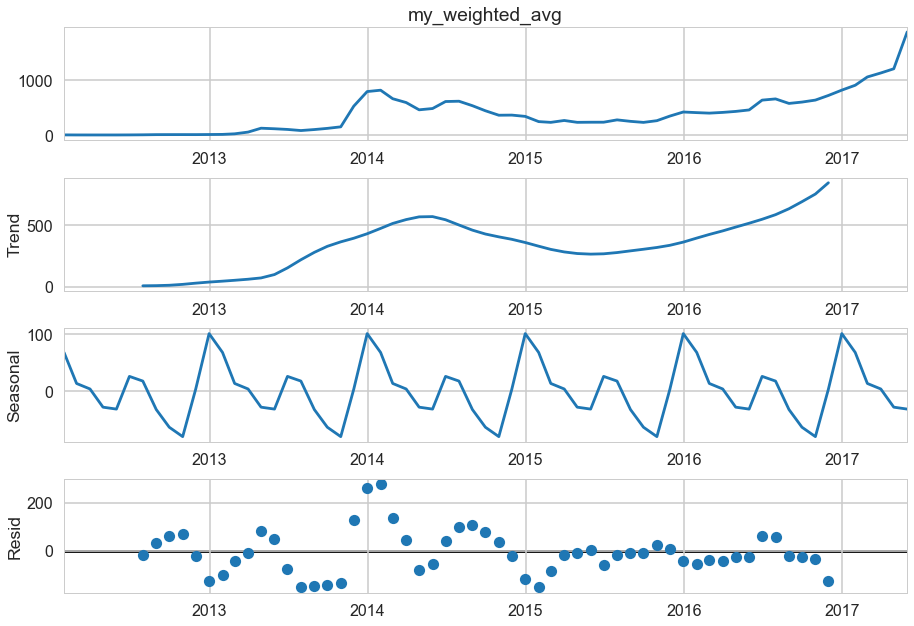

In [32]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=[15,20])

sm.tsa.seasonal_decompose(df_month.my_weighted_avg).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.my_weighted_avg)[1])
plt.show()

Observed data shows that there is a exponential rise at the end. So it means that it has non constant mean and non constant variance. Which tells that the data is not stationary and we need transformations on the same.

From seasonilty data, we can see there are some seasonal pattern so to make better models we need some transformation on the seasonal data.

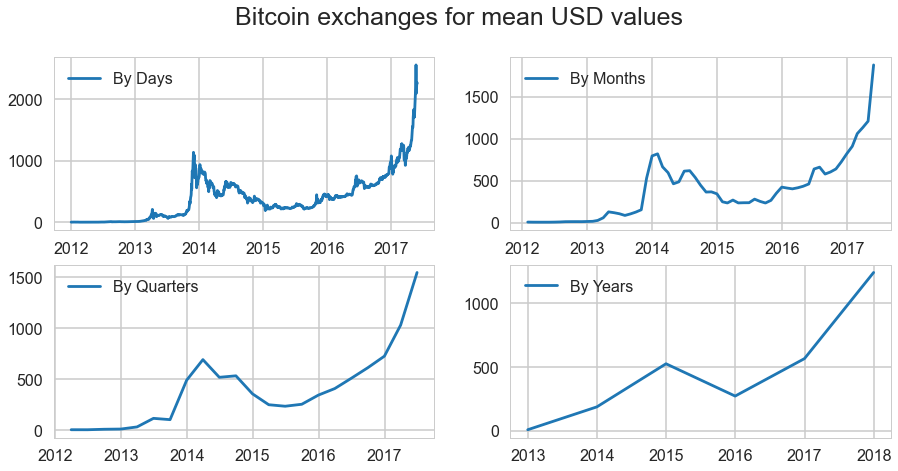

In [33]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges for mean USD values', fontsize=25)

plt.subplot(221)
plt.plot(df.my_weighted_avg, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.my_weighted_avg, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.my_weighted_avg, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.my_weighted_avg, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Since data is not stationary we perform BOXCOX transformations. To deal with non constant variance (log transformations)

In [34]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.my_weighted_avg)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.my_weighted_avg)[1])

Dickey–Fuller test: p=0.998762


Since p value of ADF test is !< 0.05 we conclude that the data is non stationary. So with these points we know that we need some transformations.

To deal with the seasonality of the data we use Seasonal differenciation and perform trnsformations on the data. This will make the data constant.

In [35]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.164857


Still the ADF test shows > 0.05 so we add more transformations. In regular diffrentiation method we are removing the non constant mean.

Dickey–Fuller test: p=0.045108


<Figure size 1080x504 with 0 Axes>

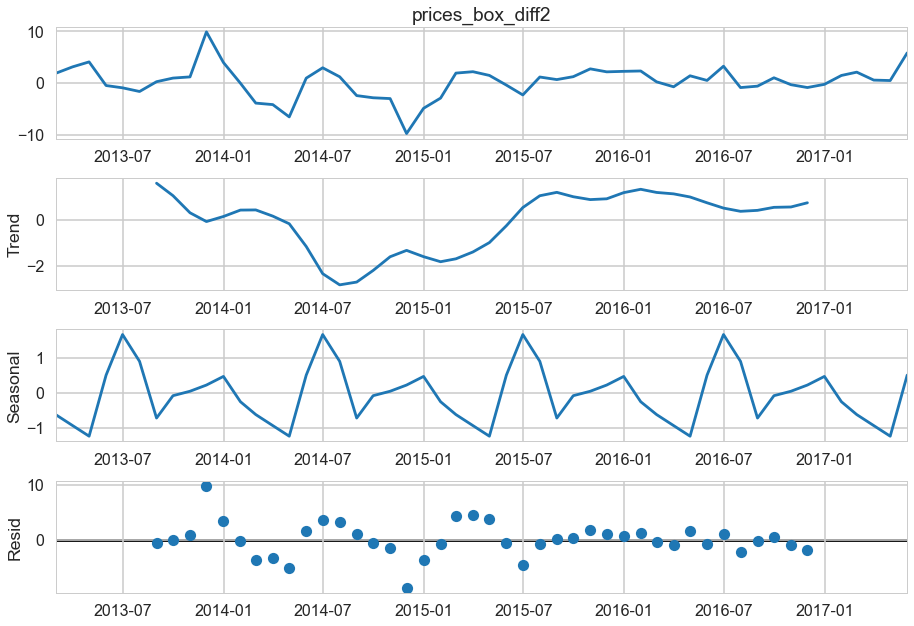

In [36]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

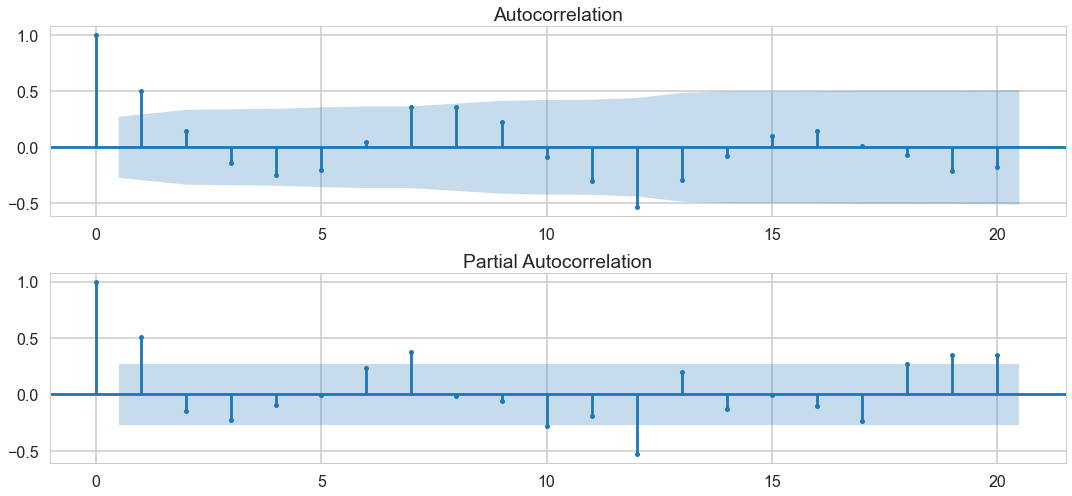

In [37]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=20, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=20, ax=ax)
plt.tight_layout()
plt.show()

From ACF abd PACF we get the values for ARIMA model. Here we are performing the operations for the model data. 

In [38]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

AIC is a model metric to calculate the best metric. Here we are finding the AIC for all the models to predict the best model.

In [39]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  231.863937
22  (1, 0, 2, 0)  231.903910
21  (1, 0, 1, 1)  231.983125
7   (0, 1, 0, 1)  232.196669
9   (0, 1, 1, 1)  232.567351
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                   65
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -112.932
Date:                              Thu, 12 May 2022   AIC                            231.864
Time:                                      11:37:03   BIC                            237.718
Sample:                                  01-31-2012   HQIC                           234.108
                                       - 05-31-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

Least AIC is chosen. That is SARIMAX with values SARIMAX(1, 1, 0)x(0, 1, 1, 12) 

Dickey–Fuller test:: p=0.000000


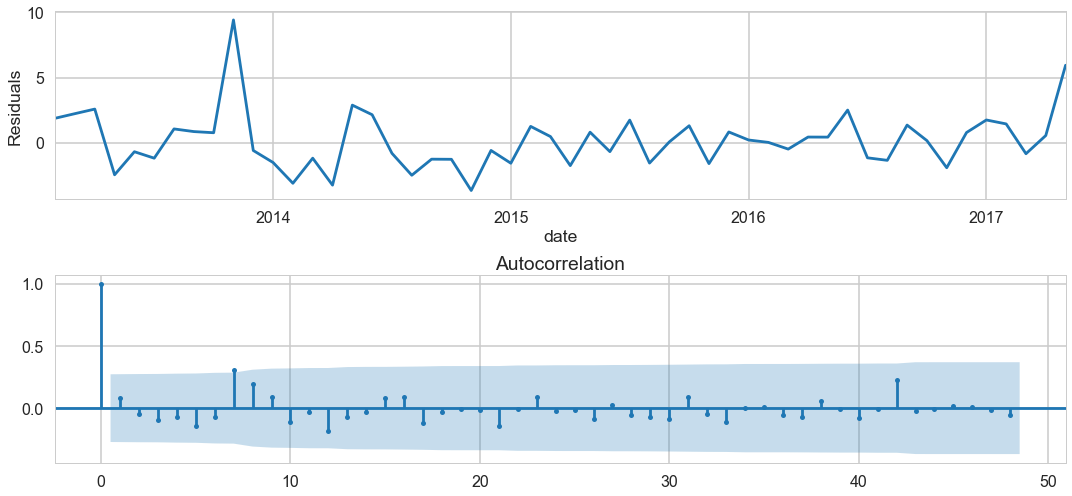

In [40]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

We are confirming that the model is stationary by plotting the ACF plot of the residuals.

In [41]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Creating inverse box cox for creating the predictions on the transformed values.

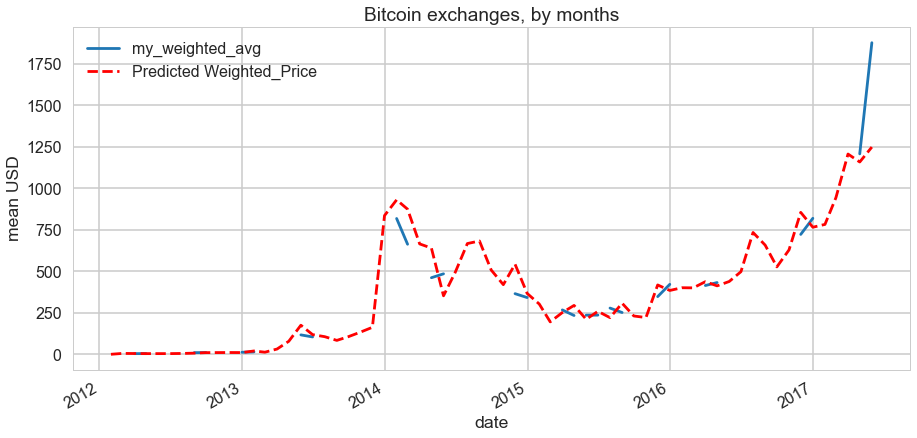

In [42]:
# Prediction for future 6 months
df_month2 = df_month[['my_weighted_avg']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2018, 2, 28), datetime(2018, 3, 28), datetime(2018, 4, 28), datetime(2018, 5, 28), ]

# print(df.head())
date_list = df_month.index
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
df_month2.my_weighted_avg.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

Here we can conclude that the model created using the transforamtions is good and predicts well.